# Gaussian Fidelity Landscapes

Mingkang got a weird looking landscape for a gaussian pulse so I am now diagonising the same thing.

In [47]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import system.experimental_september as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen_tukey
importlib.reload(pulse_gen_tukey)
import pulse.gaussian as pulse_gen_gaussian
importlib.reload(pulse_gen_gaussian)
import utils.expectation_values as expect
importlib.reload(expect)

pass

In [11]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm
_amp = 2.5 * 2 * np.pi
_off = 0
_dur = 35

# Compare Pulses

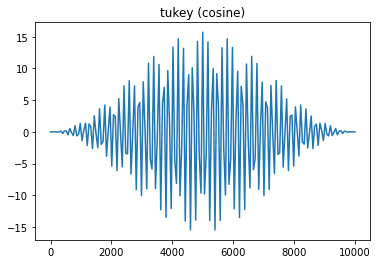

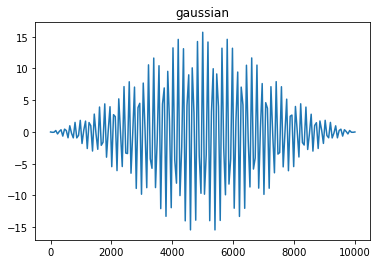

0.1434196610434575

In [60]:
tlist = np.linspace(0, 10000, int(_dur*5))
pulse_gen_tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - 0.3, ramp_coef=1, tlist=tlist)
pulse_gen_gaussian.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - 0.3, sharpness=4.5, tlist=tlist)
plt.plot(tlist, pulse_gen_tukey.get_pulse(tlist))
plt.title("tukey (cosine)")
plt.show()
plt.title("gaussian")
plt.plot(tlist, pulse_gen_gaussian.get_pulse(tlist))
plt.show()

np.mean(np.abs(np.array(pulse_gen_tukey.get_pulse(tlist)) - np.array(pulse_gen_gaussian.get_pulse(tlist))))

# Find centering offset

In [13]:
def vary_offset_tukey(off):
    tlist = np.linspace(0, _dur, int(_dur*5))
    pulse_gen_tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=1, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen_tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(-2, 2, 111)
offset_varying_results = parfor(vary_offset_tukey, offs_to_test)

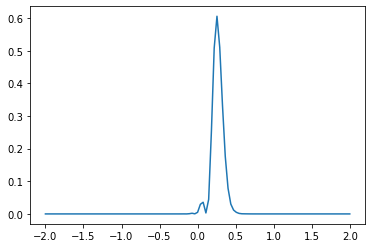

{'fidelity': 0.6057531464074914,
 'offset': 0.2545454545454544,
 'frequency': 7.628003728625671,
 'duration': 35,
 'amplitude': 15.707963267948966}

In [16]:
_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])
plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.show()
offset_varying_results[np.argmax(_fids_off_sweep)]

In [19]:
offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]

0.2545454545454544

## Use Gradient Descent to find better offset

In [22]:
import scipy
offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
parameters = [ offset, duration]
constants = [ amplitude ]

def cost_tukey(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude]
    amplitude = constants[0]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen_tukey.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=1, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen_tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    return (1-fidelity)

tukey_optimResult = scipy.optimize.minimize(cost_tukey, parameters, constants, method="Nelder-Mead", options={"disp":True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 96


In [23]:
tukey_optimResult

 final_simplex: (array([[ 0.269395  , 70.78872717],
       [ 0.26939524, 70.78872406],
       [ 0.26939532, 70.78880984]]), array([4.17233111e-07, 4.17283280e-07, 4.22440463e-07]))
           fun: 4.1723311117181083e-07
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 47
        status: 0
       success: True
             x: array([ 0.269395  , 70.78872717])

# Generate Fidelity Landscapes

In [5]:
def tukey(dur):
    global _amp, _off
    ramp_coef = 1
    tlist = np.linspace(0, dur, int(dur*2))
    pulse_gen_tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen_tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - _off,
        "duration": dur,
        "amplitude": _amp,
        "ramp_coef": ramp_coef
    }

In [24]:
tukey_results = []
iterations = 50
best_offset = 0.269395
for i in tqdm(range(0, iterations)):
    _off = np.linspace(best_offset-0.1, best_offset+0.1, iterations)[i]
    already_did_this_offset = False
    for result in tukey_results:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    tukey_results += parallel_map(tukey, np.linspace(4, 225, iterations)) # durations here

100%|██████████| 50/50 [13:32<00:00, 16.25s/it]


In [61]:
def gaus(dur):
    global _amp, _off
    sharpness = 4.5
    tlist = np.linspace(0, dur, int(dur*2))
    pulse_gen_gaussian.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, sharpness=sharpness, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen_gaussian.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - _off,
        "duration": dur,
        "amplitude": _amp,
        "sharpness": sharpness
    }

In [62]:
gaus_results = []
iterations = 50
best_offset = 0.269395
for i in tqdm(range(0, iterations)):
    _off = np.linspace(best_offset-0.1, best_offset+0.1, iterations)[i]
    already_did_this_offset = False
    for result in gaus_results:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    gaus_results += parallel_map(gaus, np.linspace(4, 225, iterations)) # durations here

100%|██████████| 50/50 [00:00<00:00, 5927.84it/s]


## Graph

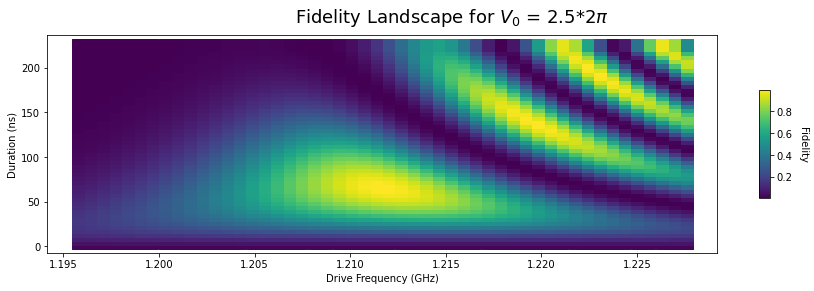

In [29]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(tukey_results)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])
    freqs.append(result["frequency"] / (2*np.pi))


fig, axs = plt.subplots(figsize=(15, 4))
fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amps[-1]/(2*np.pi)), fontsize=18)
axs.set_xlabel("Drive Frequency (GHz)")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(freqs, durs, c=fids, cmap="viridis", marker="s", s=150)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("Fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)